# Machine Learning Dunant 1

**Doel:** We bouwen een eenvoudig, reproduceerbaar ML‑proces om dagelijks gasverbruik en het beoveld‑verbruik tijdens wintermaanden te voorspellen. Het model wordt getraind op een "goed" referentiejaar zodat we daarna afwijkingen in andere jaren kunnen signaleren (bv. installatieproblemen of alarmen).

#### Waarom deze aanpak

- Praktisch: inzicht in hoe temperatuur, weekdag en vakanties het verbruik beïnvloeden.  
- Diagnostisch: voorspellingen gebruiken om afwijkend gedrag van de installatie te detecteren.  
- Reproduceerbaar: volledige pipeline (feature‑engineering → imputatie → training → opslag model → predicties).

#### Data (kort) 

- Features: weekdag (cyclisch), weeknummer (cyclisch), seizoen, weekend/vakantie flag, temp_avg, temp_min, temp_max.  
- Targets: gasverbruik, beo_opwekking (beo‑veld).  
- We gebruiken dagelijkse aggregaties; ontbrekende waardes en outliers worden expliciet behandeld.

#### Leerdoelen (wat je na de workshop kunt)

1. Data voorbereiden en tijdskenmerken cyclisch coderen.  
2. Missende waarden en outliers herkennen en behandelen.  
3. Eenvoudige preprocessing‑pipeline (imputatie, encoding, scaling) bouwen.  
4. Random Forest trainen, tunen en opslaan als productiemodel.  
5. Nieuwe periode (winter 24/25) voorbereiden en voorspellingen maken om installatiegedrag te evalueren.

#### Stappen (kort)

1. Data inlezen en verkennen  
2. Feature engineering (incl. cyclische encoding)  
3. Imputatie en outlierverwijdering  
4. Train/test split en baseline modellen vergelijken  
5. Random Forest finetunen met TimeSeriesSplit  
6. Final model trainen, opslaan en gebruiken voor 24/25‑voorspellingen  
7. Interpretatie van resultaten en vervolgstappen

#### Vereisten

- Basis Python/pandas ervaring  
- Geïnstalleerde libs: scikit‑learn, pandas, numpy, matplotlib/seaborn, joblib

#### Verwachte output

- Notebook met volledige pipeline, opgeslagen Random Forest modellen en CSV met voorspellingen voor 24/25 plus korte interpretatie van afwijkingen.

Kort en concreet: we trainen op een representatief goed jaar, bewaren het beste model en gebruiken dat model om in de winter 24/25 afwijkingen in verbruik te detecteren.

In [1]:
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Stap 1: Dataverzameling

1. Dataframe opstellen met alle dagen van 2023
2. Datum feature kolommen toevoegen
3. Weerdata toevoegen
4. y data toevoegen

### 1. Dataframe opstellen met alle dagen van 2023

In [2]:
ml_df = pd.DataFrame({'datum': pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')})
ml_df.head()

,datum
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05


### 2. Datumfeatures toevoegen

1. Dag van de week (cijfers met start op maandag)
2. Weeknummer (cijfer)
3. seizoen
4. IsWeekdag
5. IsVakantiedag

In [3]:
ml_df['weekdag'] = ml_df['datum'].dt.day_of_week
ml_df['weeknummer'] = ml_df['datum'].dt.isocalendar().week
ml_df['seizoen'] = pd.cut(ml_df['datum'].dt.month,
                         bins=[0, 3, 6, 9, 12],
                         labels=['Winter', 'Lente', 'Zomer', 'Herfst'])
ml_df['is_weekend'] = (ml_df['datum'].dt.dayofweek >= 5).astype(int)

be_holidays = holidays.BE(years=ml_df['datum'].dt.year.unique().tolist())
ml_df['is_vakantiedag'] = ml_df['datum'].isin(be_holidays).astype(int)

ml_df.head()

C:\Users\jakdvree\AppData\Local\Temp\ipykernel_22320\2471538161.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  ml_df['is_vakantiedag'] = ml_df['datum'].isin(be_holidays).astype(int)


,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag
0,2023-01-01,6,52,Winter,1,1
1,2023-01-02,0,1,Winter,0,0
2,2023-01-03,1,1,Winter,0,0
3,2023-01-04,2,1,Winter,0,0
4,2023-01-05,3,1,Winter,0,0


### 3. Weerdata toevoegen

1. Zoek het open dataplatform van het KMI
2. Download de data voor 2023 (AWS 1 dag)
3. Voeg de weerdata toe aan de dataframe
4. Het beste weerstation heeft geopunten (50.98 3.816)

In [ ]:
# Laad de weerdata in
weerdata = pd.read_csv('data/aws_1day.csv')
weerdata.head()

,FID,the_geom,code,timestamp,precip_quantity,temp_avg,temp_max,temp_min,temp_grass_pt100_avg,temp_soil_avg,...,temp_soil_avg_50cm,wind_speed_10m,wind_speed_avg_30m,wind_gusts_speed,humidity_rel_shelter_avg,pressure,sun_duration,short_wave_from_sky_avg,sun_int_avg,qc_flags
0,aws_1day.fid-661c6a34_19b238bc0c6_35c,POINT (50.916 5.45),6477,2023-11-25T00:00:00,2.89,4.54,8.46,1.92,3.39,4.18,...,9.55,2.53,NaN,11.46,90.01,1010.04,151.50,40.61,51.86,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
1,aws_1day.fid-661c6a34_19b238bc0c6_35d,POINT (51.348 3.202),6418,2023-11-21T00:00:00,1.48,10.53,11.89,8.50,NaN,NaN,...,NaN,5.30,NaN,11.64,87.82,1018.00,189.25,NaN,72.26,"{""validated"":{""PRECIP_QUANTITY"":false,""TEMP_AV..."
2,aws_1day.fid-661c6a34_19b238bc0c6_35e,POINT (50.511 6.073),6494,2023-11-27T00:00:00,35.00,-0.39,1.50,-1.07,0.48,0.49,...,6.80,4.07,NaN,11.83,99.93,920.34,0.00,4.78,1.39,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
3,aws_1day.fid-661c6a34_19b238bc0c6_35f,POINT (49.62 5.587),6484,2023-11-21T00:00:00,0.00,7.59,9.59,5.79,15.72,7.65,...,9.55,2.26,NaN,7.33,94.73,978.47,60.08,41.33,21.04,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
4,aws_1day.fid-661c6a34_19b238bc0c6_360,POINT (50.194 5.255),6472,2023-11-22T00:00:00,0.00,3.81,5.29,2.50,5.36,5.28,...,9.30,2.24,3.02,7.46,86.18,993.75,299.92,53.85,96.06,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."


In [ ]:
# Filter op de juiste geopunten
weerdata = weerdata[weerdata.the_geom == 'POINT (50.98 3.816)']
weerdata.head()

,FID,the_geom,code,timestamp,precip_quantity,temp_avg,temp_max,temp_min,temp_grass_pt100_avg,temp_soil_avg,...,temp_soil_avg_50cm,wind_speed_10m,wind_speed_avg_30m,wind_gusts_speed,humidity_rel_shelter_avg,pressure,sun_duration,short_wave_from_sky_avg,sun_int_avg,qc_flags
12,aws_1day.fid-661c6a34_19b238bc0c6_368,POINT (50.98 3.816),6434,2023-11-27T00:00:00,13.79,5.96,8.70,3.54,5.84,5.95,...,8.53,5.81,6.68,13.03,95.24,996.85,0.00,7.68,2.04,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
17,aws_1day.fid-661c6a34_19b238bc0c6_36d,POINT (50.98 3.816),6434,2023-11-25T00:00:00,17.04,5.51,7.72,3.40,4.88,5.09,...,9.08,3.26,4.52,13.38,92.03,1014.91,105.75,29.70,36.96,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
27,aws_1day.fid-661c6a34_19b238bc0c6_377,POINT (50.98 3.816),6434,2023-11-26T00:00:00,3.86,5.70,6.95,4.44,5.61,5.60,...,8.69,3.42,4.12,9.31,92.11,1014.24,0.00,25.00,7.33,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
39,aws_1day.fid-661c6a34_19b238bc0c6_383,POINT (50.98 3.816),6434,2023-11-24T00:00:00,7.98,7.22,11.73,5.11,5.34,5.82,...,9.73,5.28,6.88,16.58,78.48,1014.09,140.42,31.28,44.97,"{""validated"":{""PRECIP_QUANTITY"":true,""TEMP_AVG..."
41,aws_1day.fid-661c6a34_19b238bc0c6_385,POINT (50.98 3.816),6434,2023-11-14T00:00:00,31.77,11.10,12.42,9.52,10.03,9.94,...,10.51,5.60,6.72,14.78,91.25,1003.98,0.00,8.63,2.57,"{""validated"":{""PRECIP_QUANTITY"":false,""TEMP_AV..."


We houden volgende kolommen over: timestamp, temp_avg, temp_max, temp_min

In [ ]:
# Filter de juiste kolommen
weerdata = weerdata[['timestamp', 'temp_avg', 'temp_max', 'temp_min']]
weerdata.head()

,timestamp,temp_avg,temp_max,temp_min
12,2023-11-27T00:00:00,5.96,8.70,3.54
17,2023-11-25T00:00:00,5.51,7.72,3.40
27,2023-11-26T00:00:00,5.70,6.95,4.44
39,2023-11-24T00:00:00,7.22,11.73,5.11
41,2023-11-14T00:00:00,11.10,12.42,9.52


In [ ]:
# Hernoem de kolom timestamp naar datum en zet dit om naar een datetime object en normaliseer het
weerdata.timestamp = pd.to_datetime(weerdata.timestamp)
weerdata['datum'] = weerdata['timestamp'].dt.normalize()
weerdata.drop(columns=['timestamp'], inplace=True)

In [ ]:
# Merge (left) de data met de ml_df
ml_df = ml_df.merge(weerdata, on='datum', how='left')
ml_df.head()

,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,temp_avg,temp_max,temp_min
0,2023-01-01,6,52,Winter,1,1,12.54,14.57,10.83
1,2023-01-02,0,1,Winter,0,0,9.11,13.66,4.14
2,2023-01-03,1,1,Winter,0,0,7.46,9.72,3.55
3,2023-01-04,2,1,Winter,0,0,11.51,13.07,9.81
4,2023-01-05,3,1,Winter,0,0,10.91,11.81,9.44


In [ ]:
# 1. laad de gasteller in (data/gasteller.txt), seperator is een tap (sep='\t") en laat de header (titel kolomen) weg
gasteller = pd.read_csv('data/gasteller.txt', sep='\t', header=0)

# 2. Hernoem de kolommen naar datum en gastellerstand en verwijder de laatste kolom indien nodig
gasteller = gasteller.iloc[:, :2]
gasteller.columns = ['datum', 'gastellerstand']

# 3. Zet de datumkolom om naar een datetime object
gasteller.datum = pd.to_datetime(
    gasteller['datum'].str.split(',').str[0],  # neem alles vóór de komma
    format='%m/%d/%y',
    errors='coerce'
)

# 4. Filter de dataset zoals gezien in 2_gasketel_rendement
gasteller['verbruik'] = gasteller['gastellerstand'].diff().fillna(0)
gasteller.verbruik = gasteller.verbruik.clip(lower=0)
gasteller.verbruik = gasteller.verbruik.clip(upper=100000)
gasteller.verbruik = (gasteller.verbruik / 100) * 11.4
gasteller.head()

,datum,gastellerstand,verbruik
0,2020-02-01,0.0,0.0
1,2020-02-02,0.0,0.0
2,2020-02-03,0.0,0.0
3,2020-02-04,0.0,0.0
4,2020-02-05,0.0,0.0


In [ ]:
# Zet de datum goed, normaliseer.
gasteller['datum'] = pd.to_datetime(gasteller['datum']).dt.normalize()
gasteller = gasteller.sort_values('datum').reset_index(drop=True)

# De verbruiken worden om 12u snachts opgenomen, dus het verbruik is eigenlijk van de dag ervoor. Laten we een .shift(-1) uitvoeren op de juiste kolom!
gasteller['verbruik'] = gasteller['verbruik'].shift(-1)

# Voeg het verbruik toe aan de ml_df
ml_df['gasverbruik'] = ml_df['datum'].map(gasteller.set_index('datum')['verbruik'])
ml_df.head()

,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,temp_avg,temp_max,temp_min,gasverbruik
0,2023-01-01,6,52,Winter,1,1,12.54,14.57,10.83,68.172
1,2023-01-02,0,1,Winter,0,0,9.11,13.66,4.14,129.390
2,2023-01-03,1,1,Winter,0,0,7.46,9.72,3.55,139.878
3,2023-01-04,2,1,Winter,0,0,11.51,13.07,9.81,106.476
4,2023-01-05,3,1,Winter,0,0,10.91,11.81,9.44,109.668


In [ ]:
# lees de calorieteller uit van het beoveld
cal_beo = pd.read_csv('data/calorieteller_beo.txt', sep='\t', header=0)
cal_beo = cal_beo.iloc[:, :3]
cal_beo.columns = ['datum', 'beo_koud', 'beo_warm']
cal_beo.head()

,datum,beo_koud,beo_warm
0,"5/29/20, 12:00:00 AM CEST",0.32,0.97
1,"5/30/20, 12:00:00 AM CEST",0.35,0.98
2,"5/31/20, 12:00:00 AM CEST",0.42,0.98
3,"6/1/20, 12:00:00 AM CEST",0.44,0.98
4,"6/2/20, 12:00:00 AM CEST",0.46,0.99


In [ ]:
# Voer de zelfde bewerkingen uit, zet om naar Kwh, normaliseer en shift de opwekking_warm met -1
cal_beo.datum = pd.to_datetime(
    cal_beo['datum'].str.split(',').str[0],  # neem alles vóór de komma
    format='%m/%d/%y',
    errors='coerce'
)
cal_beo['datum'] = cal_beo['datum'].dt.normalize()
cal_beo['opwekking_warm'] = cal_beo['beo_koud'].diff().fillna(0) * 1000 # converteer naar kwh

cal_beo = cal_beo.sort_values('datum').reset_index(drop=True)
cal_beo['opwekking_warm'] = cal_beo['opwekking_warm'].shift(-1)

cal_beo.head()

,datum,beo_koud,beo_warm,opwekking_warm
0,2020-05-29,0.32,0.97,30.0
1,2020-05-30,0.35,0.98,70.0
2,2020-05-31,0.42,0.98,20.0
3,2020-06-01,0.44,0.98,20.0
4,2020-06-02,0.46,0.99,450.0


In [ ]:
# voeg de kolom toe aan ml_df
ml_df['beo_opwekking'] = ml_df['datum'].map(cal_beo.set_index('datum')['opwekking_warm'])
ml_df.head()

,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,temp_avg,temp_max,temp_min,gasverbruik,beo_opwekking
0,2023-01-01,6,52,Winter,1,1,12.54,14.57,10.83,68.172,0.0
1,2023-01-02,0,1,Winter,0,0,9.11,13.66,4.14,129.390,30.0
2,2023-01-03,1,1,Winter,0,0,7.46,9.72,3.55,139.878,510.0
3,2023-01-04,2,1,Winter,0,0,11.51,13.07,9.81,106.476,250.0
4,2023-01-05,3,1,Winter,0,0,10.91,11.81,9.44,109.668,210.0


## Stap 2: Datavisualisatie

C:\Users\jakdvree\AppData\Local\Temp\ipykernel_22320\1196426228.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=g3, x='weekdag', y='gasverbruik', ax=ax[2], palette='Blues')


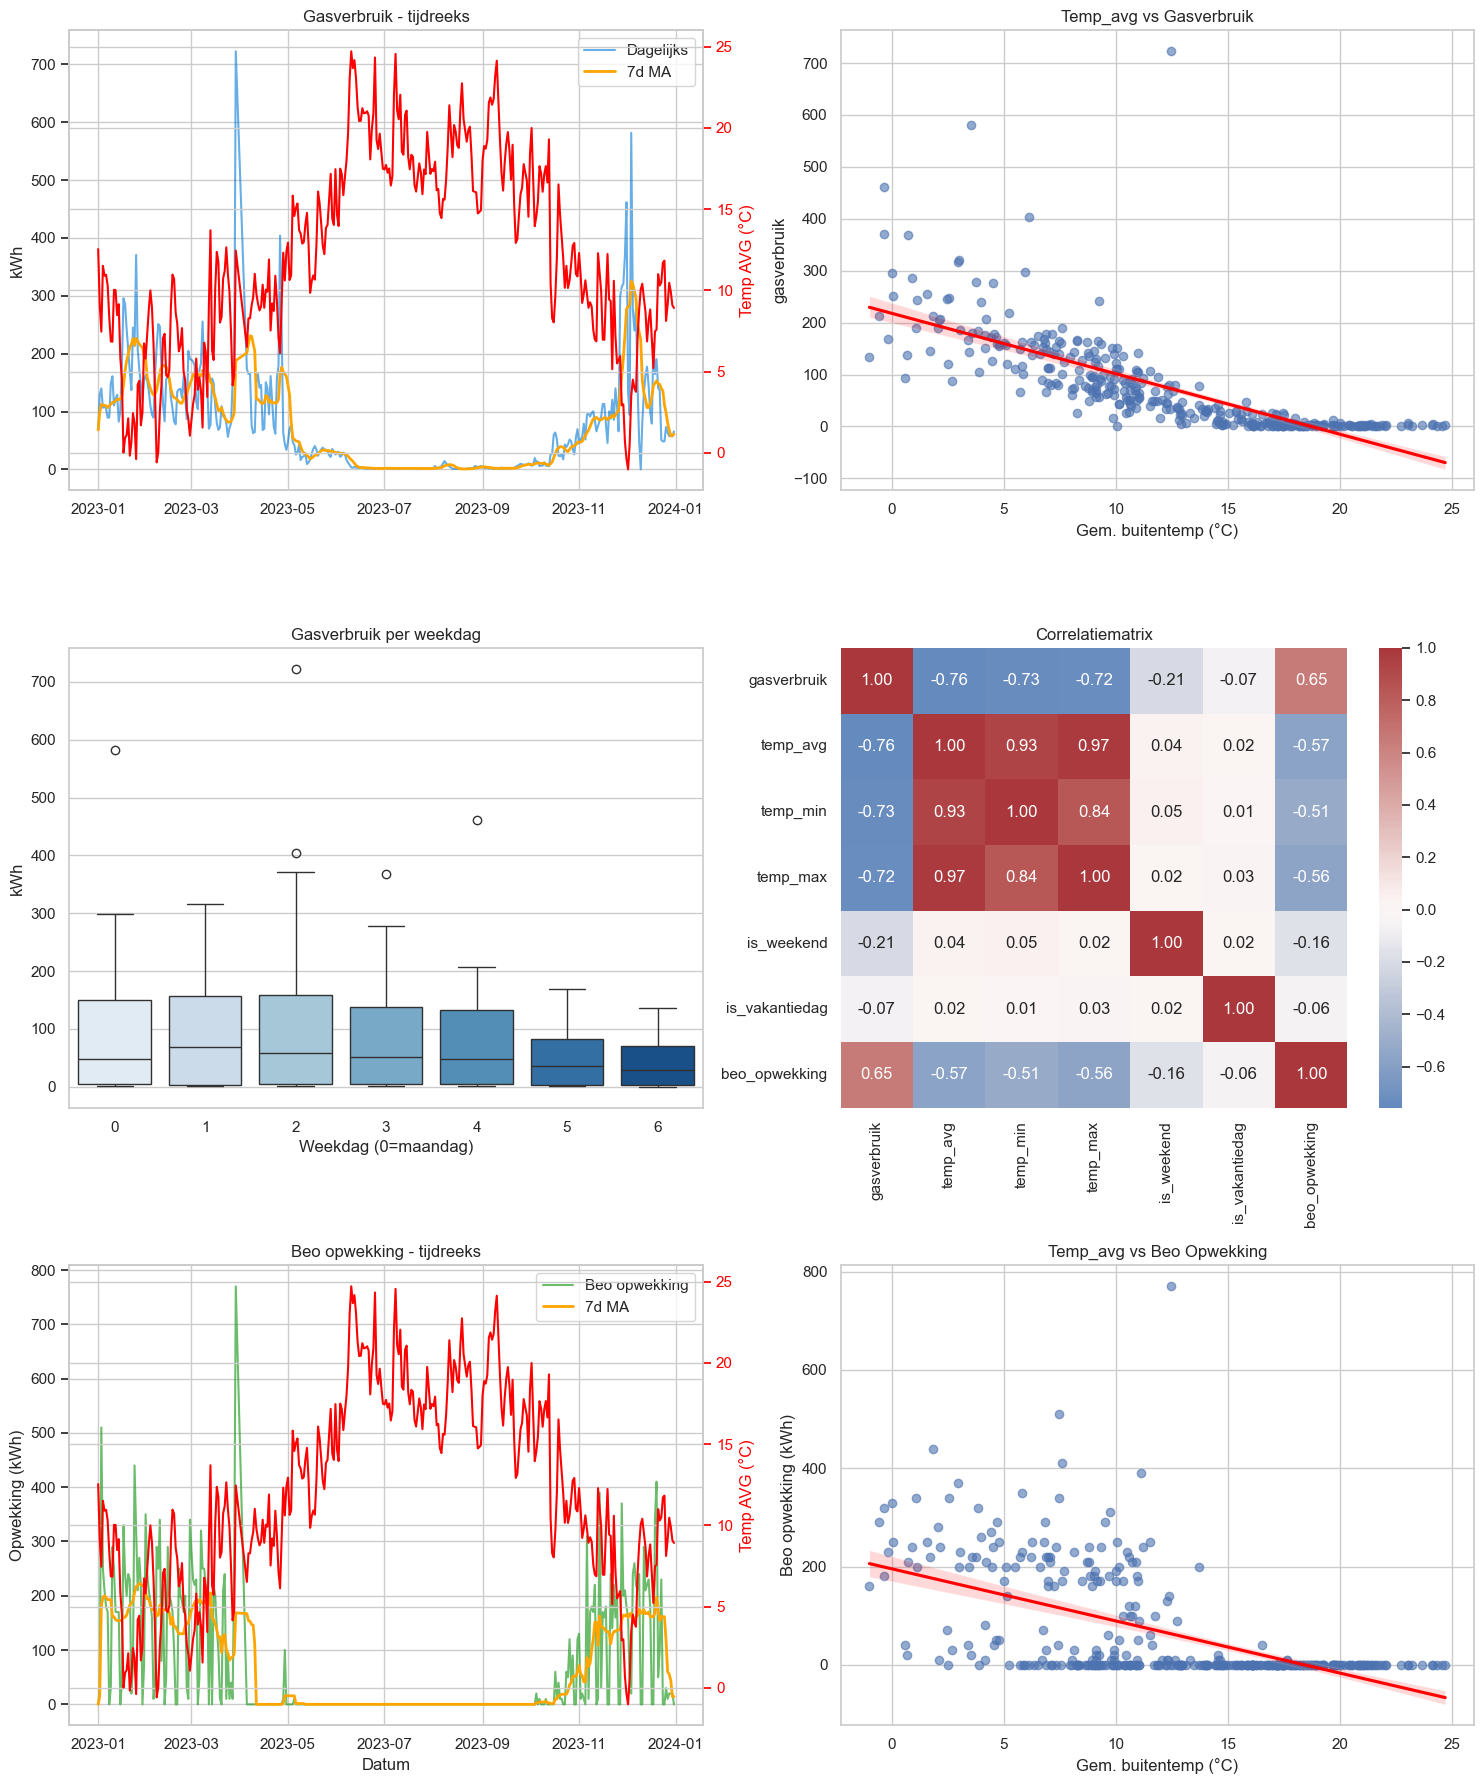

In [16]:
df = ml_df.copy()

sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
ax = axes.flatten()

# 1) Tijdreeks gasverbruik + 7-dagen rolling gemiddelde
g1 = df.dropna(subset=['gasverbruik'])
ax[0].plot(g1['datum'], g1['gasverbruik'], color='#0078D4', alpha=0.6, label='Dagelijks')
ax[0].plot(g1['datum'], g1['gasverbruik'].rolling(7, min_periods=1).mean(), color='orange', linewidth=2, label='7d MA')
ax2 = ax[0].twinx()
ax2.plot(g1['datum'], g1['temp_avg'], color='red', label='Temp AVG')
ax2.set_ylabel('Temp AVG (°C)', color='red')
ax2.tick_params(axis='y', colors='red')
ax[0].set_title('Gasverbruik - tijdreeks')
ax[0].set_ylabel('kWh')
ax[0].legend()

# 2) Scatter temp_avg vs gasverbruik (met regressielijn)
g2 = df.dropna(subset=['temp_avg','gasverbruik'])
sns.regplot(data=g2, x='temp_avg', y='gasverbruik', scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ax=ax[1])
ax[1].set_title('Temp_avg vs Gasverbruik')
ax[1].set_xlabel('Gem. buitentemp (°C)')

# 3) Boxplot gasverbruik per weekdag
g3 = df.dropna(subset=['weekdag','gasverbruik'])
sns.boxplot(data=g3, x='weekdag', y='gasverbruik', ax=ax[2], palette='Blues')
ax[2].set_title('Gasverbruik per weekdag')
ax[2].set_xlabel('Weekdag (0=maandag)')
ax[2].set_ylabel('kWh')

# 4) Correlatie heatmap van relevante features
cols = ['gasverbruik','temp_avg','temp_min','temp_max','is_weekend','is_vakantiedag','beo_opwekking']
corr = df[cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0, ax=ax[3])
ax[3].set_title('Correlatiematrix')

# 5) Beo_opwekking tijdreeks + 7-dagen MA
g5 = df.dropna(subset=['beo_opwekking'])
ax[4].plot(g5['datum'], g5['beo_opwekking'], color='#2ca02c', alpha=0.7, label='Beo opwekking')
ax[4].plot(g5['datum'], g5['beo_opwekking'].rolling(7, min_periods=1).mean(), color='orange', linewidth=2, label='7d MA')
ax4 = ax[4].twinx()
ax4.plot(g1['datum'], g1['temp_avg'], color='red', label='Temp AVG')
ax4.set_ylabel('Temp AVG (°C)', color='red')
ax4.tick_params(axis='y', colors='red')
ax[4].set_title('Beo opwekking - tijdreeks')
ax[4].set_ylabel('Opwekking (kWh)')
ax[4].set_xlabel('Datum')
ax[4].legend()

# 6) Temp_avg vs Beo_opwekking (met regressielijn)
g6 = df.dropna(subset=['temp_avg','beo_opwekking'])
sns.regplot(data=g6, x='temp_avg', y='beo_opwekking', scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ax=ax[5])
ax[5].set_title('Temp_avg vs Beo Opwekking')
ax[5].set_xlabel('Gem. buitentemp (°C)')
ax[5].set_ylabel('Beo opwekking (kWh)')

plt.tight_layout()
plt.show()

## Stap 3: Verwijderen van outliers

Deze stap is optioneel, maar sterk aan te raden. Outliers kunnen een negatief effect hebben op de prestaties van ML modellen.

### Outliers gasverbruik verwijderen

In tijdreeksdata outliers verwijderen kan een moeilijke taak zijn, je kan deze manueel gaan verwijderen, echter we zien dat het beoveld nog steeds niet optimaal werkte, maar we moeten het doen met wat we hebben. Een mogelijkheid om echte outliers slim te verwijderen is door de som te nemen van het gas en beoveld verbruik, daarbij de rolling gemiddelde te nemen, en dan de rijen die er erg uitschieten te verwijderen uit de data. Deze techniek kan je hieronder terugvinden.

In [17]:
# Stap 0: Repareer eerst de gaten in je ruwe data (Interpolatie)
# limit=5 betekent: vul gaten van max 5 dagen op. Als een gat groter is, is het misschien beter om het leeg te laten.
ml_df['gasverbruik'] = ml_df['gasverbruik'].interpolate(method='linear', limit=10)
ml_df['beo_opwekking'] = ml_df['beo_opwekking'].interpolate(method='linear', limit=10)

In [18]:
# Stap 0.1: controleer of de data compleet is
time_df = ml_df.copy()

time_df = time_df.sort_values('datum')
time_df['tijdsprong'] = time_df['datum'].diff()

gaten = time_df[time_df['tijdsprong'] > pd.Timedelta('1D')]

print('Gevonden gaten:')
print(gaten[['datum', 'tijdsprong']])

Gevonden gaten:
Empty DataFrame
Columns: [datum, tijdsprong]
Index: []


In [19]:
# Stap 1: Totaal verbruik toevoegen
ml_df['totaal_verbruik'] = ml_df['gasverbruik'] + ml_df['beo_opwekking']

In [20]:
# Stap 2: Bereken rolling statistics (bijv. per 7 dagen om weekpatronen mee te pakken)
# center=True is belangrijk: zo vergelijk je een dag met de dagen er vlak voor én erna.
window_size = 7
ml_df['rolling_mean'] = ml_df['totaal_verbruik'].rolling(window=window_size, center=True).mean()
ml_df['rolling_std'] = ml_df['totaal_verbruik'].rolling(window=window_size, center=True).std()

In [21]:
# Stap 3: Definieer outliers
# Een punt is een outlier als het meer dan X keer de standaardafwijking afwijkt van het lokale gemiddelde.
# 3 is standaard (streng), 2 is wat losser (pakt meer outliers).
sigma_threshold = 2

ml_df['is_outlier'] = (
    ml_df['totaal_verbruik'] > (ml_df['rolling_mean'] + sigma_threshold * ml_df['rolling_std'])
) | (
    ml_df['totaal_verbruik'] < (ml_df['rolling_mean'] - sigma_threshold * ml_df['rolling_std'])
)

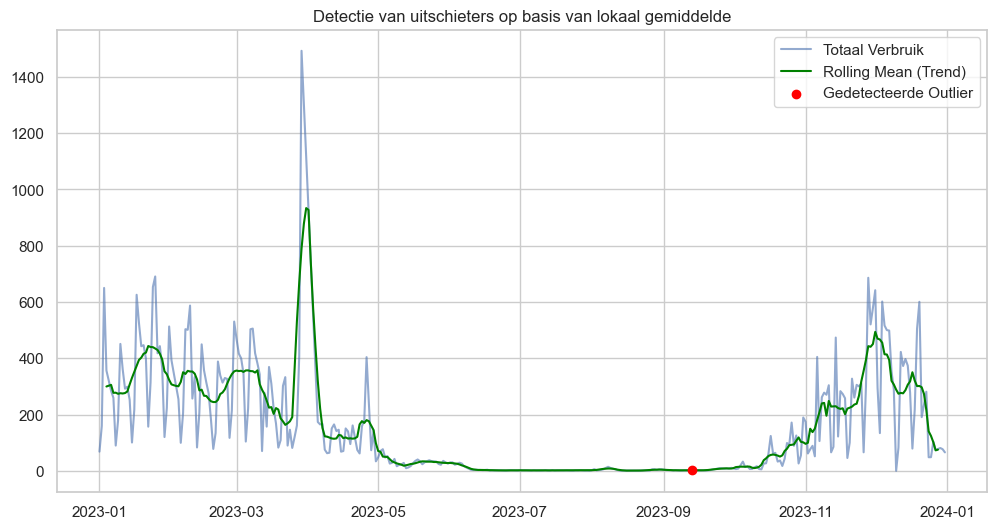

In [22]:
# Stap 4: Inspectie (belangrijk!)
# Plot de resultaten voordat je verwijdert, om te zien of je geen koude dips weggooit.
plt.figure(figsize=(12, 6))
plt.plot(ml_df['datum'], ml_df['totaal_verbruik'], label='Totaal Verbruik', alpha=0.6)
plt.plot(ml_df['datum'], ml_df['rolling_mean'], label='Rolling Mean (Trend)', color='green')
# Teken de outliers als rode punten
outliers = ml_df[ml_df['is_outlier']]
plt.scatter(outliers['datum'], outliers['totaal_verbruik'], color='red', label='Gedetecteerde Outlier', zorder=5)
plt.legend()
plt.title("Detectie van uitschieters op basis van lokaal gemiddelde")
plt.show()

We zien dat we 1 grote piek hebben, die niet wordt gededecteerd, daarnaast zien we ook dat de hele zomerperiode weinig nut heeft voor ons model. Mogelijke oplossing, data weg halen van juni tot oktober en de dagen ronde de piek manueel verwijderen.

In [23]:
# Verwijder data van juni (6) tot en met oktober (10)
# Het teken '~' betekent 'NIET', dus: behoud alles wat NIET in die maanden valt.
ml_df = ml_df[~ml_df['datum'].dt.month.between(6, 10)]

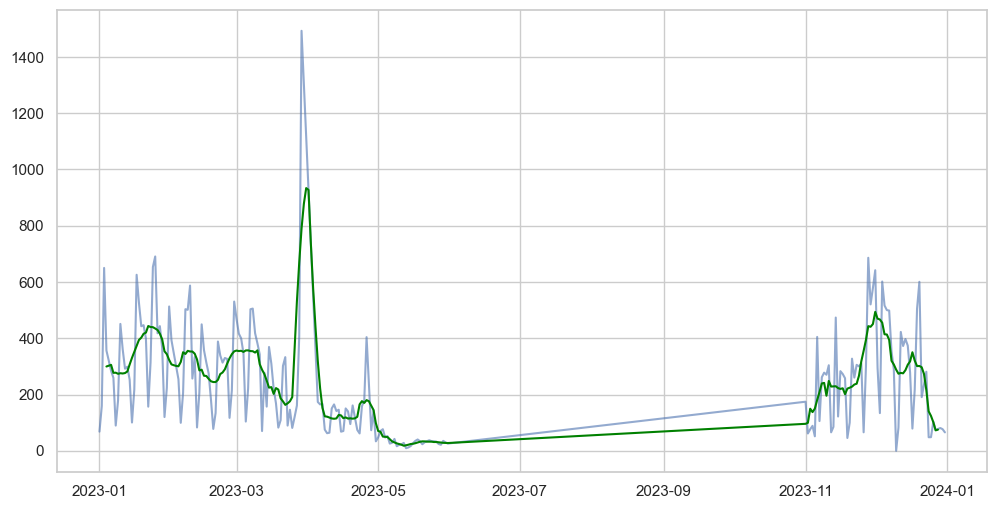

In [24]:
# Stap 4: Inspectie (belangrijk!)
# Plot de resultaten voordat je verwijdert, om te zien of je geen koude dips weggooit.
plt.figure(figsize=(12, 6))
plt.plot(ml_df['datum'], ml_df['totaal_verbruik'], label='Totaal Verbruik', alpha=0.6)
plt.plot(ml_df['datum'], ml_df['rolling_mean'], label='Rolling Mean (Trend)', color='green')
plt.show()

In [ ]:
# Verwijder rijen met meer dan 700 kwh verbruik op een dag
ml_df = ml_df[~(ml_df['totaal_verbruik'] > 700)]

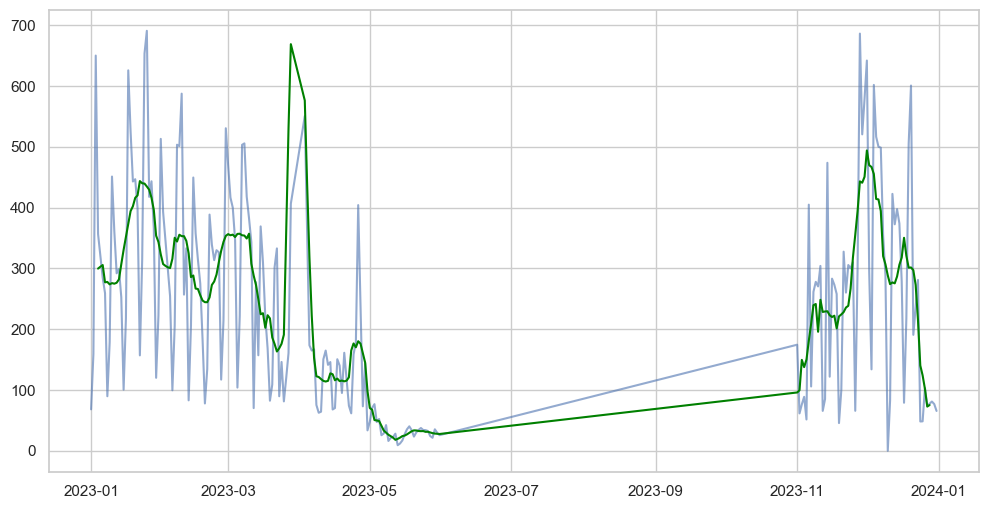

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(ml_df['datum'], ml_df['totaal_verbruik'], label='Totaal Verbruik', alpha=0.6)
plt.plot(ml_df['datum'], ml_df['rolling_mean'], label='Rolling Mean (Trend)', color='green')
plt.show()

## Stap 4: Verdelen van training en testdata

Weekdag -> tijdsvariabele en zetten we om naar cyclische waarde via sin en cos transformatie.  
weeknummer -> tijdsvariabele en zetten we om naar cyclische waarde via sin en cos transformatie.  
Seizoen -> categorische variabele en zetten we om via one-hot encoding.  
is_weekend -> binaire variabele (0 of 1)  
is_vakantiedag -> binaire variabele (0 of 1)  
temp_avg -> numerieke variabele  
temp_min -> numerieke variabele  
temp_max -> numerieke variabele  
gasverbruik -> target variabele (numeriek)  
beo_opwekking -> target variabele (numeriek)  

### Cyclische codering van tijdsvariabelen (weekdag_sin / weekdag_cos, week_sin / week_cos)

Waarom?
- Tijdgegevens zoals weekdag en weeknummer zijn cyclisch: maandag (0) en zondag (6) liggen dicht bij elkaar, maar numerieke encoding (`0..6`) negeert dat.
- Sin / cos-transformatie behoudt de cyclische structuur en geeft continue, vloeiende representaties die modellen makkelijk kunnen gebruiken.

Formule
- sin = sin(2π * value / period)
- cos = cos(2π * value / period)

Voorbeelden (gebruik in de notebook)
- Weekdag (0=maandag … 6=zondag), period = 7:
  ml_df['weekdag_sin'] = np.sin(2 * np.pi * ml_df['weekdag'] / 7)  
  ml_df['weekdag_cos'] = np.cos(2 * np.pi * ml_df['weekdag'] / 7)

- Weeknummer (ISO week 1–52/53). Vaak gebruik je 52 als period:
  ml_df['week_sin'] = np.sin(2 * np.pi * (ml_df['weeknummer'] - 1) / 52)  
  ml_df['week_cos'] = np.cos(2 * np.pi * (ml_df['weeknummer'] - 1) / 52)

Praktische tips
- Gebruik exact dezelfde encoding bij training en inference.  
- Sin/cos liggen in [-1, 1], meestal geen extra scaling nodig.  
- Als je weeknummers 53 krijgt, kies period = 53 of voorkom randen door te normaliseren naar jaarfractie.  
- Voor interpretatie kun je hoek = atan2(sin, cos) gebruiken om de oorspronkelijke fase terug te winnen.

In [28]:
# gebruik bestaande datumkolom
ml_df['weekdag_sin'] = np.sin(2 * np.pi * ml_df['weekdag'] / 7)
ml_df['weekdag_cos'] = np.cos(2 * np.pi * ml_df['weekdag'] / 7)

# weeknummer (1-52/53) naar cyclisch (zorg dat je 52 of 53 kiest afhankelijk van dataset)
ml_df['week_sin'] = np.sin(2 * np.pi * (ml_df['weeknummer'] - 1) / 52)
ml_df['week_cos'] = np.cos(2 * np.pi * (ml_df['weeknummer'] - 1) / 52)

In [29]:
# prepare features / targets, imputation + encoding + scaling pipeline, split and train
features = ['weekdag_sin','weekdag_cos','week_sin','week_cos','seizoen','is_weekend','is_vakantiedag','temp_avg','temp_max','temp_min']
targets = ['gasverbruik','beo_opwekking']

X = ml_df[features].copy()
y = ml_df[targets].copy()

In [30]:
# handle missing targets: drop rows with missing target values (preferred)
mask = y.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

In [31]:
# column groups
num_feats = ['temp_avg','temp_min','temp_max']
cat_feats = ['seizoen']
passthrough = ['weekdag_sin','weekdag_cos','week_sin','week_cos','is_weekend','is_vakantiedag']

In [32]:
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preproc = ColumnTransformer([
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
], remainder='passthrough')

In [33]:
pipelines = {
    'Linear': Pipeline([('pre', preproc), ('model', LinearRegression())]),
    'SVR': Pipeline([('pre', preproc), ('model', SVR(kernel='rbf', C=1.0))]),
    'RandomForest': Pipeline([('pre', preproc), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
}

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [35]:
# train per target and collect metrics
results = []
for tgt in targets:
    ytr = y_train[tgt].values
    yte = y_test[tgt].values
    for name, pipe in pipelines.items():
        pipe.fit(X_train, ytr)
        preds = pipe.predict(X_test)
        mae = mean_absolute_error(yte, preds)
        rmse = np.sqrt(mean_squared_error(yte, preds))  # vervangt squared=False
        results.append({'target': tgt, 'model': name, 'MAE': mae, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values(['target','RMSE']).reset_index(drop=True)
print(results_df)

          target         model         MAE        RMSE
0  beo_opwekking  RandomForest   44.011905   62.965117
1  beo_opwekking        Linear   70.566940   83.993681
2  beo_opwekking           SVR  102.065902  139.216297
3    gasverbruik        Linear   33.069037   41.710873
4    gasverbruik  RandomForest   28.872109   44.063133
5    gasverbruik           SVR   47.367246   57.361667


### Verder gaan met Random Forest

In [36]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. Maak een lege dictionary om je modellen in te bewaren
best_models = {} 

rf_pipe = Pipeline([('pre', preproc), ('model', RandomForestRegressor(random_state=42))])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__max_features': ['sqrt', 0.5]
}

tscv = TimeSeriesSplit(n_splits=3)
results = []

for tgt in targets:
    print(f"Start training voor target: {tgt}")
    ytr = y_train[tgt].values
    yte = y_test[tgt].values

    gs = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    gs.fit(X_train, ytr)

    best = gs.best_estimator_
    
    # 2. HIER SLAAN WE HET MODEL OP
    best_models[tgt] = best
    
    preds = best.predict(X_test)
    mae = mean_absolute_error(yte, preds)

    results.append({'target': tgt,
                    'model': 'RandomForest',
                    'best_params': gs.best_params_,
                    'MAE': mae
                    })

    # (Feature importance code blijft hetzelfde...)
    try:
        feat_names = best.named_steps['pre'].get_feature_names_out(X_train.columns)
    except Exception:
        feat_names = np.array([f'f{i}' for i in range(best.named_steps['pre'].transform(X_train.iloc[:1]).shape[1])])

    importances = best.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)
    print(f"Top features voor {tgt}:\n", fi.to_string())

results_df = pd.DataFrame(results).sort_values(['target','MAE']).reset_index(drop=True)
print("\nSamenvatting:\n", results_df)

Start training voor target: gasverbruik
Top features voor gasverbruik:
 num__temp_avg                0.262518
num__temp_min                0.206348
num__temp_max                0.181287
remainder__week_cos          0.077338
remainder__weekdag_sin       0.069782
remainder__week_sin          0.060387
remainder__is_weekend        0.046690
cat__seizoen_Winter          0.030689
remainder__weekdag_cos       0.023462
cat__seizoen_Herfst          0.022995
cat__seizoen_Lente           0.015196
remainder__is_vakantiedag    0.003309
Start training voor target: beo_opwekking
Top features voor beo_opwekking:
 remainder__weekdag_sin       0.190275
remainder__week_cos          0.189805
remainder__weekdag_cos       0.144617
num__temp_max                0.113894
cat__seizoen_Lente           0.089177
num__temp_avg                0.085328
num__temp_min                0.070768
remainder__week_sin          0.060630
remainder__is_weekend        0.032986
cat__seizoen_Winter          0.015086
cat__seizoen_Her

## Maken van voorspelling voor 24-25

De winter van 24/25 was een dubbelle winter, de eerste helft verliep alles vrij goed, de 2de helft lag de warmtepomp vaak in alarm en behaalde ze haar target niet. Laten we zien of we dit kunnen voorspellen!

### Stap 1: Dataframe maken

We maken een dataframe van 2024-10-01 tot 2025-05-01.

In [ ]:
# Maak een dataframe voor de winter van 24-25
ml_2425 = pd.DataFrame({'datum': pd.date_range(start='2024-10-01', end='2025-05-01', freq='D')})
ml_2425.head()

,datum
0,2024-10-01
1,2024-10-02
2,2024-10-03
3,2024-10-04
4,2024-10-05


In [ ]:
# Voeg de datumfeatures toe
ml_2425['weekdag'] = ml_2425['datum'].dt.day_of_week
ml_2425['weeknummer'] = ml_2425['datum'].dt.isocalendar().week
ml_2425['seizoen'] = pd.cut(ml_2425['datum'].dt.month,
                         bins=[0, 3, 6, 9, 12],
                         labels=['Winter', 'Lente', 'Zomer', 'Herfst'])
ml_2425['is_weekend'] = (ml_2425['datum'].dt.dayofweek >= 5).astype(int)

be_holidays = holidays.BE(years=ml_df['datum'].dt.year.unique().tolist())
ml_2425['is_vakantiedag'] = ml_2425['datum'].isin(be_holidays).astype(int)

# Voeg de sin en cos toe voor week en weekdag
# gebruik bestaande datumkolom
ml_2425['weekdag_sin'] = np.sin(2 * np.pi * ml_2425['weekdag'] / 7)
ml_2425['weekdag_cos'] = np.cos(2 * np.pi * ml_2425['weekdag'] / 7)

# weeknummer (1-52/53) naar cyclisch (zorg dat je 52 of 53 kiest afhankelijk van dataset)
ml_2425['week_sin'] = np.sin(2 * np.pi * (ml_2425['weeknummer'] - 1) / 52)
ml_2425['week_cos'] = np.cos(2 * np.pi * (ml_2425['weeknummer'] - 1) / 52)

ml_2425.head()

C:\Users\jakdvree\AppData\Local\Temp\ipykernel_22320\9409498.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  ml_2425['is_vakantiedag'] = ml_2425['datum'].isin(be_holidays).astype(int)


,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,weekdag_sin,weekdag_cos,week_sin,week_cos
0,2024-10-01,1,40,Herfst,0,0,0.781831,0.623490,-1.0,-0.0
1,2024-10-02,2,40,Herfst,0,0,0.974928,-0.222521,-1.0,-0.0
2,2024-10-03,3,40,Herfst,0,0,0.433884,-0.900969,-1.0,-0.0
3,2024-10-04,4,40,Herfst,0,0,-0.433884,-0.900969,-1.0,-0.0
4,2024-10-05,5,40,Herfst,1,0,-0.974928,-0.222521,-1.0,-0.0


In [ ]:
# Verwerk weerdata, gedownload van opendata kmi en verwerk dit met de juiste kolommen
weerdata = pd.read_csv('data/aws_1day_2425.csv')
weerdata = weerdata[weerdata.the_geom == 'POINT (50.98 3.816)']
weerdata = weerdata[['timestamp', 'temp_avg', 'temp_max', 'temp_min']]
weerdata.timestamp = pd.to_datetime(weerdata.timestamp)
weerdata['datum'] = weerdata['timestamp'].dt.normalize()
weerdata.drop(columns=['timestamp'], inplace=True)
weerdata.head()

,temp_avg,temp_max,temp_min,datum
7,8.37,10.56,6.73,2024-11-17
10,8.84,11.15,5.84,2024-11-12
19,9.07,10.38,8.26,2024-11-10
20,9.49,10.55,8.23,2024-11-06
47,11.82,15.92,9.40,2024-10-22


In [ ]:
# Voeg de data toe aan ml_2425
ml_2425 = ml_2425.merge(weerdata, on='datum', how='inner')
ml_2425.head()

,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,weekdag_sin,weekdag_cos,week_sin,week_cos,temp_avg,temp_max,temp_min
0,2024-10-01,1,40,Herfst,0,0,0.781831,0.623490,-1.0,-0.0,12.87,16.20,8.17
1,2024-10-02,2,40,Herfst,0,0,0.974928,-0.222521,-1.0,-0.0,10.94,15.82,4.97
2,2024-10-03,3,40,Herfst,0,0,0.433884,-0.900969,-1.0,-0.0,10.01,14.70,4.69
3,2024-10-04,4,40,Herfst,0,0,-0.433884,-0.900969,-1.0,-0.0,8.05,15.08,2.45
4,2024-10-05,5,40,Herfst,1,0,-0.974928,-0.222521,-1.0,-0.0,8.60,16.29,1.87


In [ ]:
# Voeg het gasverbruik toe voor 2425
ml_2425['gasverbruik'] = ml_2425['datum'].map(gasteller.set_index('datum')['verbruik'])
ml_2425.head()

,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,weekdag_sin,weekdag_cos,week_sin,week_cos,temp_avg,temp_max,temp_min,gasverbruik
0,2024-10-01,1,40,Herfst,0,0,0.781831,0.623490,-1.0,-0.0,12.87,16.20,8.17,80.940
1,2024-10-02,2,40,Herfst,0,0,0.974928,-0.222521,-1.0,-0.0,10.94,15.82,4.97,81.396
2,2024-10-03,3,40,Herfst,0,0,0.433884,-0.900969,-1.0,-0.0,10.01,14.70,4.69,87.666
3,2024-10-04,4,40,Herfst,0,0,-0.433884,-0.900969,-1.0,-0.0,8.05,15.08,2.45,85.728
4,2024-10-05,5,40,Herfst,1,0,-0.974928,-0.222521,-1.0,-0.0,8.60,16.29,1.87,57.912


In [ ]:
# Voeg beoveld gegevens toe voor 2425
ml_2425['beo_opwekking'] = ml_2425['datum'].map(cal_beo.set_index('datum')['opwekking_warm'])
ml_2425.head()

,datum,weekdag,weeknummer,seizoen,is_weekend,is_vakantiedag,weekdag_sin,weekdag_cos,week_sin,week_cos,temp_avg,temp_max,temp_min,gasverbruik,beo_opwekking
0,2024-10-01,1,40,Herfst,0,0,0.781831,0.623490,-1.0,-0.0,12.87,16.20,8.17,80.940,60.0
1,2024-10-02,2,40,Herfst,0,0,0.974928,-0.222521,-1.0,-0.0,10.94,15.82,4.97,81.396,10.0
2,2024-10-03,3,40,Herfst,0,0,0.433884,-0.900969,-1.0,-0.0,10.01,14.70,4.69,87.666,60.0
3,2024-10-04,4,40,Herfst,0,0,-0.433884,-0.900969,-1.0,-0.0,8.05,15.08,2.45,85.728,100.0
4,2024-10-05,5,40,Herfst,1,0,-0.974928,-0.222521,-1.0,-0.0,8.60,16.29,1.87,57.912,70.0


Maak voorspellingen voor gasverbruik en beo_opwekking

In [43]:
# 3. Zorg dat de kolommen in exact dezelfde volgorde staan als tijdens de training
features = ['weekdag_sin','weekdag_cos','week_sin','week_cos','seizoen',
            'is_weekend','is_vakantiedag','temp_avg','temp_max','temp_min']

# Selecteer de X voor 2025
X_2025 = ml_2425[features].copy()

       datum   pred_gas  pred_beo
0 2024-10-01   71.70828      80.3
1 2024-10-02   80.20014      71.6
2 2024-10-03   94.27629      57.4
3 2024-10-04  139.20996      68.4
4 2024-10-05  107.37888      53.2


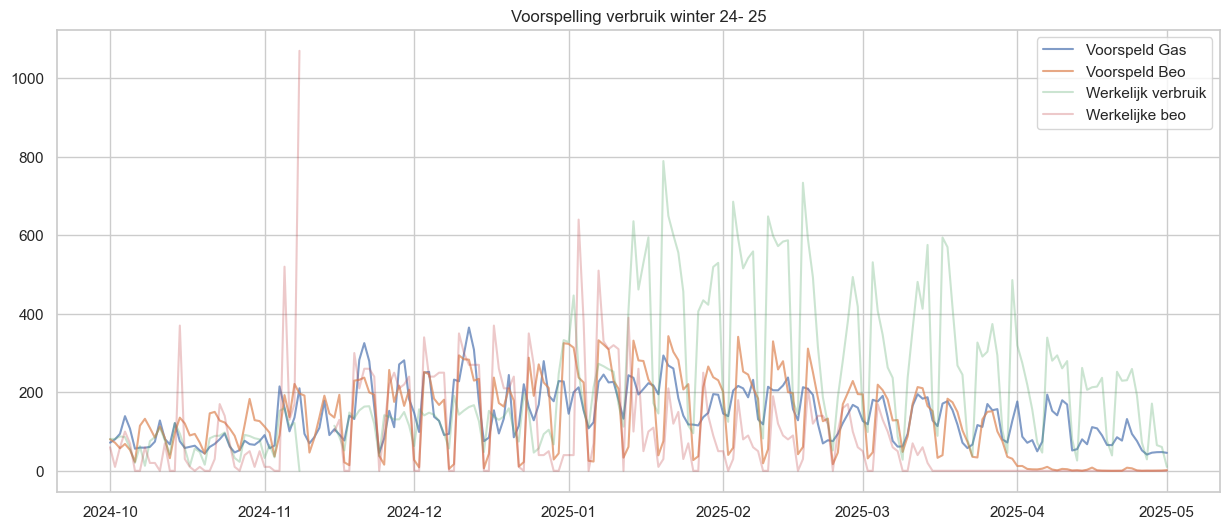

In [44]:
# Voorspel gasverbruik met het gas-model
# Het model (pipeline) regelt zelf de scaling/encoding, dus we kunnen X_2025 direct invoeren
ml_2425['pred_gas'] = best_models['gasverbruik'].predict(X_2025)

# Voorspel beo veld met het beo-model
ml_2425['pred_beo'] = best_models['beo_opwekking'].predict(X_2025)

# Resultaat bekijken
print(ml_2425[['datum', 'pred_gas', 'pred_beo']].head())

# Eventueel visualiseren
plt.figure(figsize=(15, 6))
plt.plot(ml_2425['datum'], ml_2425['pred_gas'], label='Voorspeld Gas', alpha=0.7)
plt.plot(ml_2425['datum'], ml_2425['pred_beo'], label='Voorspeld Beo', alpha=0.7)
plt.plot(ml_2425['datum'], ml_2425['gasverbruik'], label='Werkelijk verbruik', alpha=0.3)
plt.plot(ml_2425['datum'], ml_2425['beo_opwekking'], label='Werkelijke beo', alpha=0.3)
plt.title("Voorspelling verbruik winter 24- 25")
plt.legend()
plt.show()